In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report, confusion_matrix

In [53]:
df = pd.read_csv('data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [54]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [30]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [31]:
df.isna().sum()/len(df)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [55]:
df.drop('Cabin',axis=1,inplace=True)
df['Age'].fillna(df['Age'].mean(),inplace=True)
df['Embarked'].fillna(df['Embarked'].mode(),inplace=True)

<AxesSubplot:ylabel='Frequency'>

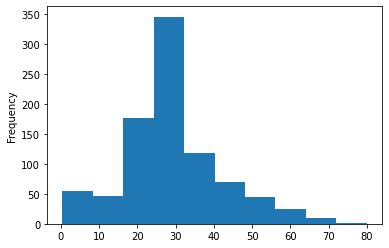

In [4]:
df['Age'].plot.hist()

In [57]:
age_bins = [0,4,7,15,30,45,60,80]
labels = [0,1,2,3,4,5,6]
df['Age_binned'] = pd.cut(df['Age'], bins=age_bins, labels=labels)

df['Age_binned'][df['Survived']==1].value_counts()/df['Age_binned'].value_counts().sort_values()

0    0.675000
1    0.700000
2    0.454545
3    0.335984
4    0.425743
5    0.407407
6    0.227273
Name: Age_binned, dtype: float64

In [58]:
label_encoder = LabelEncoder()
df[['Pclass','Sex','Embarked']] = df[['Pclass','Sex','Embarked']].apply(label_encoder.fit_transform)
df[['Pclass','Sex','Embarked']] 

,Pclass,Sex,Embarked
0,2,1,2
1,0,0,0
2,2,0,2
3,0,0,2
4,2,1,2
...,...,...,...
886,1,1,2
887,0,0,2
888,2,0,2
889,0,1,0


In [11]:
df[['Pclass','Sex','Embarked']].isna().sum()

Pclass      0
Sex         0
Embarked    0
dtype: int64

In [59]:
# Drop unused features
df.drop(['Name','Age','Ticket','Fare','PassengerId'],axis=1,inplace=True)

In [60]:
# Split dataset in train and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(['Survived'],axis = 1),df['Survived'], test_size=0.3, random_state=42)

In [61]:
# Baseline model considers that all women survived and all men died
y_baseline = X_valid['Sex']==0 # sex = 0 is female

print('confusion matrix:\n',confusion_matrix(y_valid,y_baseline),'\n')
print(classification_report(y_valid, y_baseline),'\n')

confusion matrix:
 [[134  23]
 [ 33  78]] 

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       157
           1       0.77      0.70      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268
 



In [62]:
# First model: Decision Tree
clf = tree.DecisionTreeClassifier()

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_valid)

print('confusion matrix:\n',confusion_matrix(y_valid,y_pred),'\n')
print(classification_report(y_valid, y_pred),'\n')

confusion matrix:
 [[138  19]
 [ 37  74]] 

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       157
           1       0.80      0.67      0.73       111

    accuracy                           0.79       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.79      0.79      0.79       268
 



In [63]:
# Second model: optimizing hyper parameters of Decision ree
espaco_hiperparametros ={
    'max_depth': randint(1, 11),
    'min_samples_leaf': randint(1, 11)
}
model = tree.DecisionTreeClassifier()
rand_search = RandomizedSearchCV(model, espaco_hiperparametros, cv=3, n_iter=10)
search = rand_search.fit(X_train, y_train)

print('mean_test_score: ',rand_search.cv_results_['mean_test_score'].mean(),'\n')
print('best_params_: ',rand_search.best_params_,'\n')

y_pred_grid = search.predict(X_valid)

print('confusion matrix:\n',confusion_matrix(y_valid,y_pred_grid),'\n')
print(classification_report(y_valid, y_pred_grid),'\n')

mean_test_score:  0.8128367707172055 

best_params_:  {'max_depth': 5, 'min_samples_leaf': 6} 

confusion matrix:
 [[145  12]
 [ 41  70]] 

              precision    recall  f1-score   support

           0       0.78      0.92      0.85       157
           1       0.85      0.63      0.73       111

    accuracy                           0.80       268
   macro avg       0.82      0.78      0.79       268
weighted avg       0.81      0.80      0.80       268
 

